# Overview of `tobler`s Interpolation Methods

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from tobler.dasymetric import masked_area_interpolate
from tobler.model import glm
from tobler.area_weighted import area_interpolate
from libpysal.examples import load_example

Let's say we want to represent the poverty rate and male employment using zip code geographies, but the only data available is at the census-tract level. The `tobler` package provides several different ways to estimate data collected at one geography using the boundaries of a different geography. 

## Load Data

First we'll grab two geodataframes representing chaleston, sc--one with census tracts and the other with zctas

In [2]:
c1 = load_example('Charleston1')
c2 = load_example('Charleston2')

Since areal interpolation uses spatial ovelays, we should make sure to use a reasonable projection. If a `tobler` detects that a user is performing an analysis on an unprojected geodataframe, it will do its best to reproject the data into the appropriate UTM zone to ensure accuracy. All the same, its best to set the CRS explicitly

In [3]:
crs = 6569  # https://epsg.io/6569

In [4]:
tracts = gpd.read_file(c1.get_path('sc_final_census2.shp')).to_crs(crs)

In [5]:
zip_codes = gpd.read_file(c2.get_path('CharlestonMSA2.shp')).to_crs(crs)

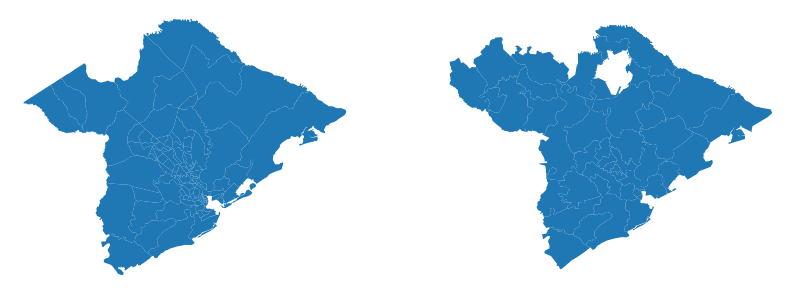

In [6]:
fig, ax = plt.subplots(1,2, figsize=(14,7))

tracts.plot(ax=ax[0])
zip_codes.plot(ax=ax[1])

for ax in ax:
    ax.axis('off')

In [7]:
tracts.columns

Index(['FIPS', 'MSA', 'TOT_POP', 'POP_16', 'POP_65', 'WHITE_', 'BLACK_',
       'ASIAN_', 'HISP_', 'MULTI_RA', 'MALES', 'FEMALES', 'MALE1664',
       'FEM1664', 'EMPL16', 'EMP_AWAY', 'EMP_HOME', 'EMP_29', 'EMP_30',
       'EMP16_2', 'EMP_MALE', 'EMP_FEM', 'OCC_MAN', 'OCC_OFF1', 'OCC_INFO',
       'HH_INC', 'POV_POP', 'POV_TOT', 'HSG_VAL', 'POLYID', 'geometry'],
      dtype='object')

In [8]:
tracts['pct_poverty'] = tracts.POV_POP/tracts.POV_TOT

## Areal Interpolation

The simplest technique available in `tobler` is simple areal interpolation in which variables from the source data are weighted according to the overlap between source and target polygons, then reaggregated to fit the target polygon geometries

In [9]:
results = area_interpolate(source_df=tracts, target_df=zip_codes, intensive_variables=['pct_poverty'], extensive_variables=['EMP_MALE'])

Text(0.5, 0.98, 'Male Employment (extensive)')

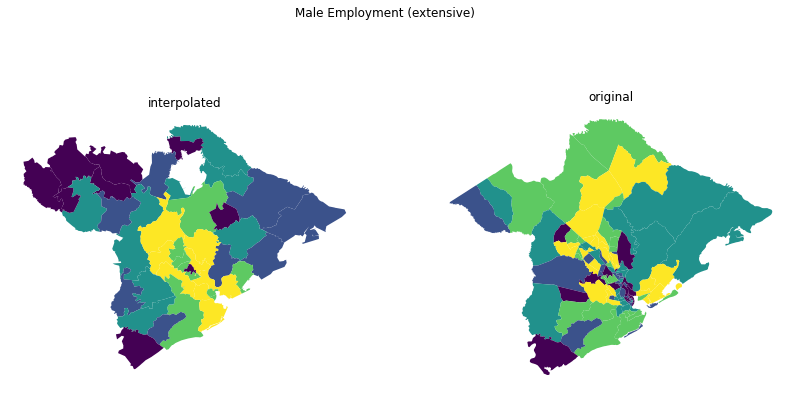

In [10]:
fig, ax = plt.subplots(1,2, figsize=(14,7))

results.plot('EMP_MALE', scheme='quantiles',  ax=ax[0])
tracts.plot('EMP_MALE', scheme='quantiles',  ax=ax[1])

ax[0].set_title('interpolated')
ax[1].set_title('original')
for ax in ax:
    ax.axis('off')
fig.suptitle('Male Employment (extensive)')

Text(0.5, 0.98, 'Poverty Rate (intensive)')

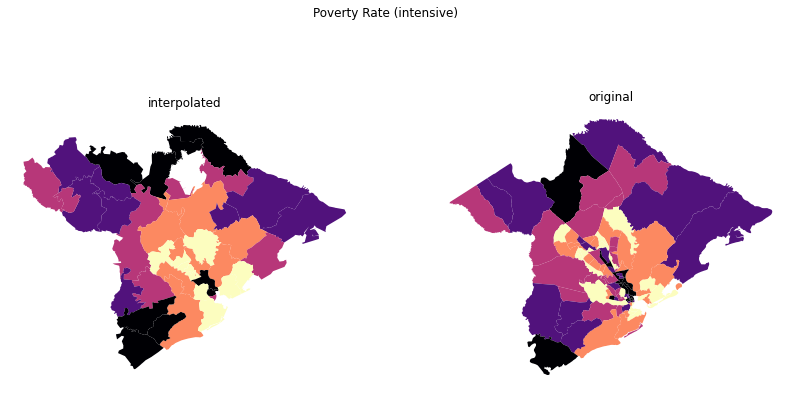

In [11]:
fig, ax = plt.subplots(1,2, figsize=(14,7))

results.plot('pct_poverty', scheme='quantiles', cmap='magma',  ax=ax[0])
tracts.plot('pct_poverty', scheme='quantiles', cmap='magma',  ax=ax[1])

ax[0].set_title('interpolated')
ax[1].set_title('original')
for ax in ax:
    ax.axis('off')
fig.suptitle('Poverty Rate (intensive)')

---

## Dasymetric Interpolation

To help improve accuracy in interpolation we can use axiliary information to mask out areas we know aren't inhabited. For example we can use raster data like <https://www.mrlc.gov/national-land-cover-database-nlcd-2016> to mask out uninhabited land uses. To do so, we need to provide a path to the raster and a list of pixel values that are considered developed. Default values are taken from NLCD

`tobler` can accept any kind of raster data that can be read by rasterio, so you can provide your own, or download directly from NLCD linked above. Alternatively, you can download a compressed version of the NLCD we host in the spatialucr quilt bucket using three short lines of code:

In [12]:
from quilt3 import Package
p = Package.browse("rasters/nlcd", "s3://spatial-ucr")
p["nlcd_2011.tif"].fetch()

Loading manifest: 100%|██████████| 3/3 [00:00<00:00, 8.92k/s]
100%|██████████| 1.54G/1.54G [00:09<00:00, 154MB/s] 


PackageEntry('file:///home/serge/projects/tobler/notebooks/nlcd_2011.tif')

In [13]:
results = masked_area_interpolate(raster="nlcd_2011.tif", 
                                  source_df=tracts, 
                                  target_df=zip_codes, 
                                  intensive_variables=['pct_poverty'], 
                                  extensive_variables=['EMP_MALE'])

/home/serge/projects/tobler/tobler/area_weighted/area_interpolate.py:461: UserWarning: The CRS for the generated union will be set to be the same as source_df.
  warnings.warn(
/home/serge/anaconda3/envs/tobler/lib/python3.9/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


Text(0.5, 0.98, 'Male Employment (extensive)')

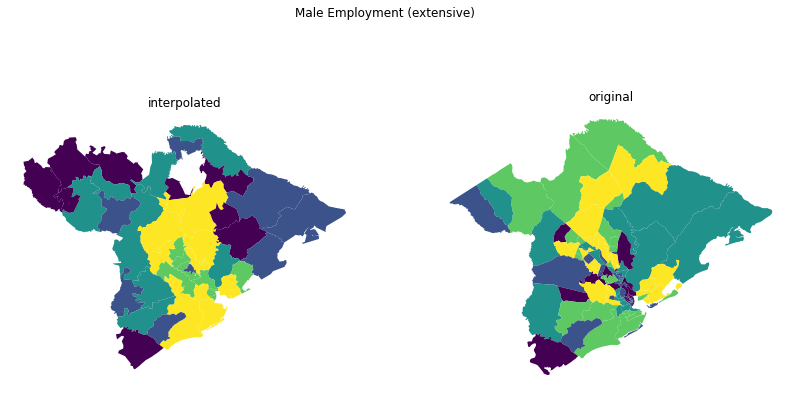

In [14]:
fig, ax = plt.subplots(1,2, figsize=(14,7))

results.plot('EMP_MALE', scheme='quantiles',   ax=ax[0])
tracts.plot('EMP_MALE', scheme='quantiles',  ax=ax[1])

ax[0].set_title('interpolated')
ax[1].set_title('original')
for ax in ax:
    ax.axis('off')
fig.suptitle('Male Employment (extensive)')

Text(0.5, 0.98, 'Poverty Rate (intensive)')

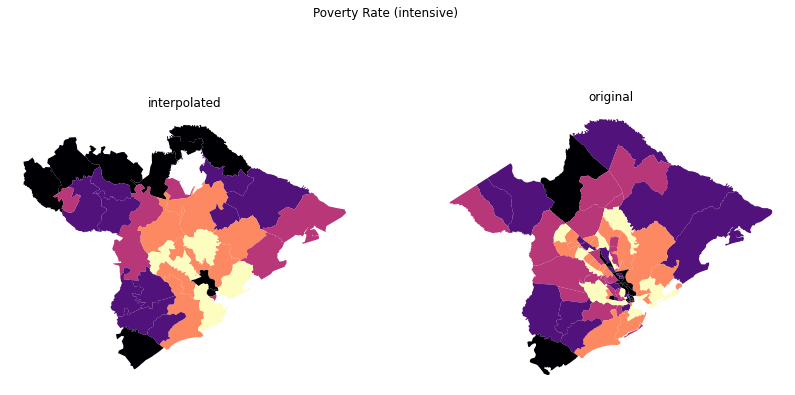

In [15]:
fig, ax = plt.subplots(1,2, figsize=(14,7))

results.plot('pct_poverty', scheme='quantiles', cmap='magma',  ax=ax[0])
tracts.plot('pct_poverty', scheme='quantiles', cmap='magma',  ax=ax[1])

ax[0].set_title('interpolated')
ax[1].set_title('original')
for ax in ax:
    ax.axis('off')
fig.suptitle('Poverty Rate (intensive)')

---

## Model-Based Interpolation

Rather than assume that extensive and intensive variables are distributed uniformly throughout developed land, tobler can also use a model-based approach to assign weights to different cell types, e.g. if we assume that "high intensity development" raster cells are likely to contain more people than "low intensity development", even though we definitely want to allocate population to both types. In these cases, `tobler` consumes a raster layer as additional input and a patsy-style model formula string. A default formula string is provided but results can be improved by fitting a model more appropriate for local settings

Unlike area weighted and dasymetric techniques, model-based interpolation estimates only a single variable at a time

In [16]:
emp_results = glm(raster="nlcd_2011.tif",source_df=tracts, target_df=zip_codes, variable='EMP_MALE', )

/home/serge/anaconda3/envs/tobler/lib/python3.9/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/serge/anaconda3/envs/tobler/lib/python3.9/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/serge/anaconda3/envs/tobler/lib/python3.9/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Text(0.5, 0.98, 'Male Employment (extensive)')

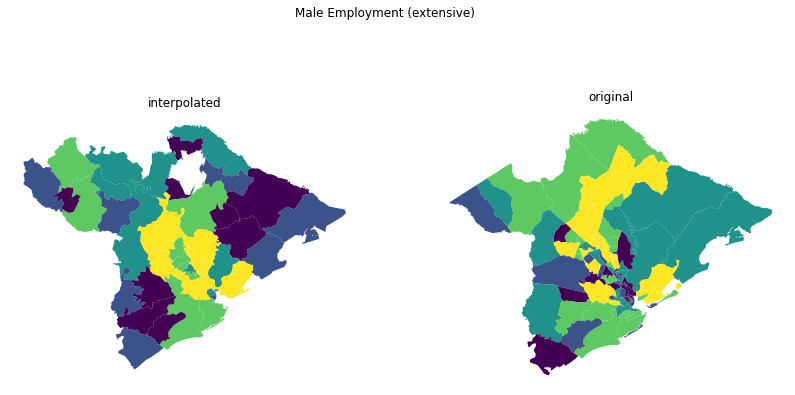

In [17]:
fig, ax = plt.subplots(1,2, figsize=(14,7))

emp_results.plot('EMP_MALE', scheme='quantiles',  ax=ax[0])
tracts.plot('EMP_MALE', scheme='quantiles', ax=ax[1])

ax[0].set_title('interpolated')
ax[1].set_title('original')
for ax in ax:
    ax.axis('off')
fig.suptitle('Male Employment (extensive)')

In [18]:
pov_results = glm(raster="nlcd_2011.tif",source_df=tracts, target_df=zip_codes, variable='pct_poverty', )

/home/serge/anaconda3/envs/tobler/lib/python3.9/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/serge/anaconda3/envs/tobler/lib/python3.9/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/serge/anaconda3/envs/tobler/lib/python3.9/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Text(0.5, 0.98, 'Poverty Rate (intensive)')

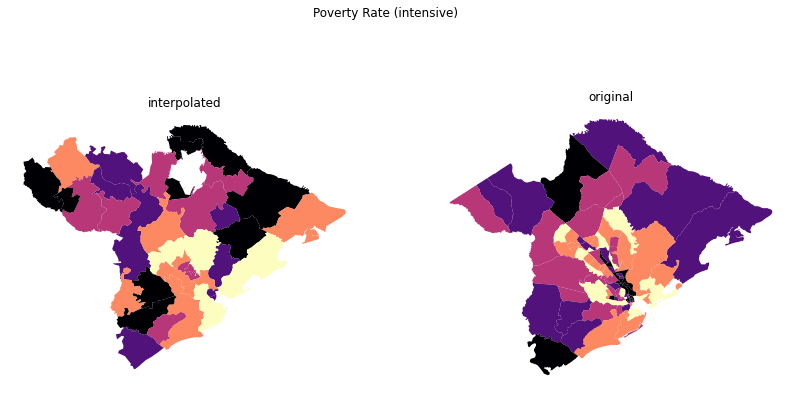

In [19]:
fig, ax = plt.subplots(1,2, figsize=(14,7))

pov_results.plot('pct_poverty', scheme='quantiles', cmap='magma',  ax=ax[0])
tracts.plot('pct_poverty', scheme='quantiles', cmap='magma',  ax=ax[1])

ax[0].set_title('interpolated')
ax[1].set_title('original')
for ax in ax:
    ax.axis('off')
fig.suptitle('Poverty Rate (intensive)')

conda remove --name myenv --allFrom the maps, it looks like the model-based approach is better at estimating the extensive variable (male employment) than the intensive variable (poverty rate), at least using the default regression equation. That's not a surprising result, though, because its much easier to intuit the relationship between land-use types and total employment levels than land-use type and poverty rate